In [295]:
import random
import matplotlib.pyplot as plt

num_villes=50
def generate_weighted_adjacency_matrix(n):
    # Générer une matrice d'adjacence vide
    adjacency_matrix = [[0] * n for _ in range(n)]

    # Générer des liens aléatoires
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < 0.6:  # Probabilité de lien entre deux villes
                weight = random.randint(1, 1000)  # Poids du lien entre deux villes
                adjacency_matrix[i][j] = weight
                adjacency_matrix[j][i] = weight
                

    return adjacency_matrix

adj_matrix = generate_weighted_adjacency_matrix(num_villes)

import numpy as np

def generate_demands(num_clients, max_demand):
    np.random.seed(42)
    demands = np.random.randint(1, max_demand+1, size=num_clients)
    return demands

def generate_vehicle_capacities(num_vehicles, total_demand):
    np.random.seed(42)
    capacities = np.random.randint(1, total_demand, size=num_vehicles, dtype=np.int64)
    return capacities

def divide_matrix(matrix, num_parts):
    size = len(matrix) // num_parts
    divided_matrix = []
    for i in range(num_parts):
        start_row = i * size
        end_row = (i + 1) * size
        divided_rows = matrix[start_row:end_row]
        divided_matrix.append(divided_rows)
    
   

    return divided_matrix




num_clients = num_villes - 1  # Exclure le dépôt
total_demand = sum([sum(row) for row in adj_matrix])  # Calculer la somme des demandes de tous les clients
max_demand = total_demand // num_clients  # Demande maximale par client





In [320]:
import numpy as np
import matplotlib.pyplot as plt

def solve_cvrp(distance_matrix, num_vehicles, depot, demands, vehicle_capacities, offset):
    num_nodes = len(distance_matrix)

    # Initialisation des variables
    routes = []
    remaining_capacities = vehicle_capacities.copy()
    visited = np.zeros(num_nodes, dtype=bool)

    # Ajouter une valeur fictive pour le dépôt dans les tableaux visited et demands
    visited[depot] = True
    demands = np.insert(demands, depot, 0)

    # Fonction pour trouver le prochain nœud à visiter
    def select_next_node(current_node, remaining_capacities):
        nonlocal visited
        feasible_nodes = [
            node for node in range(num_nodes)
            if not visited[node] and demands[node] <= remaining_capacities and distance_matrix[current_node][node] != float('inf')
        ]
        if not feasible_nodes:
            return None
        next_node = min(feasible_nodes, key=lambda node: distance_matrix[current_node][node] if distance_matrix[current_node][node] != 0 else float('inf'))

        return next_node


    # Parcours des véhicules
    for vehicle in range(num_vehicles):
        route = [depot]
        remaining_capacity = vehicle_capacities[vehicle]
        current_node = depot

        # Parcours des nœuds
        while True:
            next_node = select_next_node(current_node, remaining_capacity)
            if next_node is None:
                break
            route.append(next_node)
            visited[next_node] = True
            remaining_capacity -= demands[next_node]
            current_node = next_node

        route.append(depot)  # Retour au dépôt
        routes.append(route)

    return routes



def calculate_route_length(route, distance_matrix):
    length = 0
    for i in range(len(route) - 1):
        current_city = route[i]
        next_city = route[i + 1]
        length += distance_matrix[current_city][next_city]
    return length


num_vehicles = 3
depot = 0
demands = generate_demands(num_clients, max_demand)
vehicle_capacities = generate_vehicle_capacities(num_vehicles, total_demand)

divided_matrix = divide_matrix(adj_matrix, num_vehicles)


routes = solve_cvrp(divided_matrix[0], 1, depot, demands, vehicle_capacities, offset=0)
for i in range(1, num_vehicles):
    offset = i * (len(adj_matrix) // num_vehicles)
    routes.extend(solve_cvrp(divided_matrix[i], 1, depot, demands, vehicle_capacities, offset=offset))


# Récupérer les vrais indices de ville en ajustant l'offset
final_routes = []
for i, route in enumerate(routes):
    offset = i * (num_villes // num_vehicles)  # Calcul de l'offset
    adjusted_route = [node + offset for node in route]  # Ajustement des indices
    adjusted_route = [depot] + adjusted_route + [depot]  # Ajout du dépôt au début et à la fin de l'itinéraire
    final_routes.append(adjusted_route)


# Afficher les routes finales
for i, route in enumerate(final_routes):
    print(f"Route du camion {i+1}: {route}")


for i, route in enumerate(final_routes):
    route_length = calculate_route_length(route, adj_matrix)
    print(f"Longueur du chemin du camion {i+1}: {route_length}")


Route du camion 1: [0, 0, 7, 15, 14, 4, 1, 6, 8, 2, 10, 13, 9, 3, 12, 5, 11, 0, 0]
Route du camion 2: [0, 16, 29, 19, 27, 22, 21, 26, 17, 24, 28, 30, 31, 25, 23, 18, 20, 16, 0]
Route du camion 3: [0, 32, 33, 46, 35, 37, 43, 41, 45, 47, 34, 38, 39, 40, 36, 42, 44, 32, 0]
Longueur du chemin du camion 1: 4840
Longueur du chemin du camion 2: 4974
Longueur du chemin du camion 3: 3551


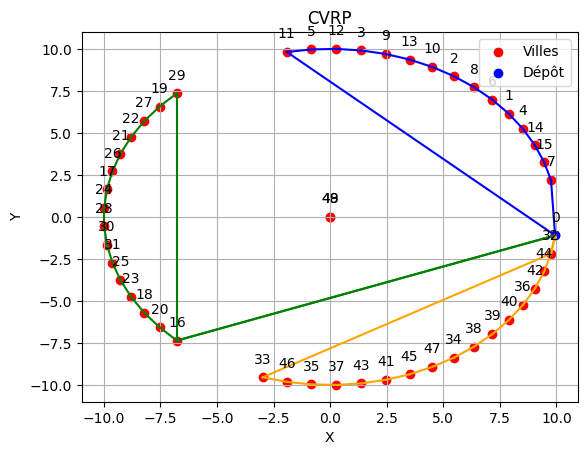

In [321]:
import numpy as np
import matplotlib.pyplot as plt

def plot_graph(distance_matrix, routes):
    num_nodes = len(distance_matrix)
    num_vehicles = len(routes)
    # Création des coordonnées des nœuds
    coords = np.zeros((num_nodes, 2))
    
    # Répartir les sous-matrices en cercles concentriques pour éviter les chevauchements
    radius = 10
    angle_step = 2 * np.pi / num_vehicles
    
    for i, route in enumerate(routes):
        angle = i * angle_step
        for j, node in enumerate(route):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            coords[node] = [x, y]
            angle += angle_step / len(route)  # Ajuster l'angle pour les nœuds de la route
    
    # Tracer les nœuds
    plt.scatter(coords[:, 0], coords[:, 1], c='red', label='Villes')

# Tracer les arcs entre les nœuds selon les routes
    colors = ['blue', 'green', 'orange', 'purple', 'cyan']  # Couleurs pour chaque camion
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]  # Sélectionner une couleur de manière cyclique
        for j in range(len(route) - 1):
            node1 = route[j]
            node2 = route[j + 1]
            x = [coords[node1][0], coords[node2][0]]
            y = [coords[node1][1], coords[node2][1]]
            plt.plot(x, y, color=color)
    
    # Marquer le dépôt
    depot_coords = coords[0]  # Coordonnées du dépôt (indice 0)
    plt.scatter(depot_coords[0], depot_coords[1], c='blue', label='Dépôt')
    
    # Ajouter les étiquettes des nœuds
    for i in range(num_nodes):
        plt.annotate(str(i), (coords[i][0], coords[i][1]), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Afficher la légende et le graphe
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('CVRP')
    plt.grid(True)
    plt.show()

# Utilisation :
plot_graph(adj_matrix, final_routes)

## Code CVRP - ACO

In [318]:
import numpy as np
import matplotlib.pyplot as plt

def solve_cvrp(distance_matrix, num_vehicles, depot, demands, vehicle_capacities, offset):
    num_nodes = len(distance_matrix)

    # Initialisation des variables
    routes = []
    remaining_capacities = vehicle_capacities.copy()
    visited = np.zeros(num_nodes, dtype=bool)

    # Ajouter une valeur fictive pour le dépôt dans les tableaux visited et demands
    visited[depot] = True
    demands = np.insert(demands, depot, 0)

    # Fonction pour trouver le prochain nœud à visiter
    def select_next_node(current_node, remaining_capacities):
        nonlocal visited
        feasible_nodes = [
            node for node in range(num_nodes)
            if not visited[node] and demands[node] <= remaining_capacities and distance_matrix[current_node][node] != float('inf')
        ]
        if not feasible_nodes:
            return None
        next_node = min(feasible_nodes, key=lambda node: distance_matrix[current_node][node] if distance_matrix[current_node][node] != 0 else float('inf'))

        return next_node


    # Parcours des véhicules
    for vehicle in range(num_vehicles):
        route = [depot]
        remaining_capacity = vehicle_capacities[vehicle]
        current_node = depot

        # Parcours des nœuds
        while True:
            next_node = select_next_node(current_node, remaining_capacity)
            if next_node is None:
                break
            route.append(next_node)
            visited[next_node] = True
            remaining_capacity -= demands[next_node]
            current_node = next_node

        route.append(depot)  # Retour au dépôt
        routes.append(route)

    return routes



def calculate_route_length(route, distance_matrix):
    length = 0
    for i in range(len(route) - 1):
        current_city = route[i]
        next_city = route[i + 1]
        length += distance_matrix[current_city][next_city]
    return length


num_vehicles = 3
depot = 0
demands = generate_demands(num_clients, max_demand)
vehicle_capacities = generate_vehicle_capacities(num_vehicles, total_demand)

divided_matrix = divide_matrix(adj_matrix, num_vehicles)

remaining_capacities = vehicle_capacities.copy()

#####################################"" Define ACO parameters
num_ants = 2
evaporation_rate = 0.5
pheromone_importance = 1.0
distance_importance = 2.0
num_iterations = 10

# Initialize pheromone matrix
pheromone_matrix = np.ones_like(adj_matrix) * 0.01

# Define the ant's construction phase
def construct_solution(distance_matrix, pheromone_matrix, demands, remaining_capacities, depot, num_nodes):
    visited = np.zeros(num_nodes, dtype=bool)
    visited[depot] = True
    demands = np.insert(demands, depot, 0)
    current_node = depot
    solution = [depot]

    while True:
        feasible_nodes = [
            node for node in range(num_nodes)
            if not visited[node] and demands[node] <= remaining_capacities[node] and distance_matrix[current_node][node] != float('inf') and distance_matrix[current_node][node] != 0
        ]
        if not feasible_nodes:
            break

        probabilities = []
        distances = []
        for node in feasible_nodes:
            pheromone = pheromone_matrix[current_node][node]
            distance = distance_matrix[current_node][node]
            heuristic = 1.0 / distance
            probabilities.append((pheromone ** pheromone_importance) * (heuristic ** distance_importance))
            distances.append(distance)

        probabilities = np.array(probabilities)
        probabilities /= np.sum(probabilities)

        next_node = np.random.choice(feasible_nodes, p=probabilities)

        solution.append(next_node)
        visited[next_node] = True
        remaining_capacities[int(next_node)] -= demands[int(next_node)]
        current_node = next_node

    solution.append(depot)
    return solution


# Effectuer l'algorithme ACO
best_solution = None
best_length = float('inf')

for iteration in range(num_iterations):
    solutions = []
    lengths = []

    for ant in range(num_ants):
        for i in range(num_vehicles):
            divided_matrix_size = len(divided_matrix)  # Size of the divided matrix
            remaining_capacities = vehicle_capacities.copy()  # Initialize remaining_capacities for the specific divided matrix
            solution = construct_solution(divided_matrix[i], pheromone_matrix, demands, remaining_capacities, depot, divided_matrix_size)
            length = calculate_route_length(solution, divided_matrix[i])
            solutions.append(solution)
            lengths.append(length)

            if length < best_length:
                best_solution = solution
                best_length = length


    for j in range(num_villes):
        for k in range(num_villes):
            if j != k:
                pheromone_matrix[j][k] *= evaporation_rate
                for ant in range(num_ants):
                    if k in solutions[ant] and j in solutions[ant]:
                        pheromone_matrix[j][k] += (1.0 / lengths[ant])


# Print the best solution found
print("Best solution:", best_solution)
print("Best length:", best_length)




Best solution: [0, 1, 0]
Best length: 69
